In [1]:
import pandas as pd 
import spacy

In [50]:
phab_path = "/mmfs1/gscratch/comdata/users/mjilg/mw-repo-lifecycles/case1/0228_ve_phab_comments.csv"
phab_df = pd.read_csv(phab_path)

In [51]:
#find gerrit phab PHID: PHID-USER-idceizaw6elwiwm5xshb
phab_df['isGerrit'] = phab_df['AuthorPHID'] == 'PHID-USER-idceizaw6elwiwm5xshb'
#cleaning df
phab_df['id'] = phab_df.index + 1
#may have to build out the reply_to column 
phab_df['reply_to'] = phab_df.groupby('TaskPHID')['id'].shift()
phab_df['reply_to'] = phab_df['reply_to'].where(pd.notnull(phab_df['reply_to']), None)

phab_df = phab_df.rename(columns={
    'comment_text': 'text',
    'AuthorPHID': 'speaker',
    'TaskPHID': 'conversation_id',
    'WMFaffil':'meta.affil',
    'isGerrit': 'meta.gerrit'
})

#look for set of prior commenters and then add onto new set each time, just new or not

# after 11-1-2012 before 11-1-2013
phab_df['timestamp'] = pd.to_datetime(phab_df['date_created'], unit='s', origin='unix', utc=True)
filtered_phab_df = phab_df[(phab_df['date_created'] < 1383264000) & (phab_df['date_created'] > 1351728000)]

#removing headless conversations
task_phab_df = filtered_phab_df[filtered_phab_df['comment_type']=="task_description"]
headed_task_phids = task_phab_df['conversation_id'].unique()
filtered_phab_df = filtered_phab_df[filtered_phab_df['conversation_id'].isin(headed_task_phids)]

#removing gerrit comments 
comment_phab_df = filtered_phab_df[filtered_phab_df['meta.gerrit'] != True]

In [52]:
unique_conversation_ids = len(comment_phab_df['conversation_id'].unique())
unique_ids = len(comment_phab_df['id'].unique())
unique_speakers = len(comment_phab_df['speaker'].unique())

print(f"Unique conversation_ids: {unique_conversation_ids}")
print(f"Unique ids: {unique_ids}")
print(f"Unique speakers: {unique_speakers}")

Unique conversation_ids: 2081
Unique ids: 8804
Unique speakers: 230


In [53]:
import re

def preprocess_text(text):
    text = str(text)
    text = text.replace('*', ' ')
    text = text.replace('-', ' ')
    text = re.sub(r'http\S+', '', text)
    return text

In [54]:
comment_phab_df['processed_text'] = comment_phab_df['text'].apply(preprocess_text)

/tmp/ipykernel_82094/3649688126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['processed_text'] = comment_phab_df['text'].apply(preprocess_text)


In [ ]:
# TODO: add coreference resolution here, possibly... 

In [55]:
nlp = spacy.load("en_core_web_sm")

def extract_dependency_tree(sentence):
    doc = nlp(sentence)
    return [(token.text, token.lemma_, token.dep_, token.head.text, token.ancestors, token.subtree, token.children) for token in doc]

In [56]:
comment_phab_df['dependency_tree'] = comment_phab_df['processed_text'].apply(extract_dependency_tree)

/tmp/ipykernel_82094/2805711855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['dependency_tree'] = comment_phab_df['processed_text'].apply(extract_dependency_tree)


In [57]:
#get VAD scores
import numpy as np
#https://saifmohammad.com/WebPages/nrc-vad.html
column_headings = ['Word', 'Valence', 'Arousal', 'Domination']
vad_lexicon = pd.read_csv('NRC-VAD-Lexicon.txt', delimiter='\t', header=None, names=column_headings)
vad_dict = vad_lexicon.set_index('Word').T.to_dict()

def vad_scoring(dependency_tree):
    valence = []
    arousal = []
    dominance = []
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            valence.append(vad_dict[lemma]['Valence'])
            arousal.append(vad_dict[lemma]['Arousal'])
            dominance.append(vad_dict[lemma]['Domination'])

    # Compute average scores across the comment
    avg_valence = np.mean(valence) if valence else 0
    avg_arousal = np.mean(arousal) if arousal else 0
    avg_dominance = np.mean(dominance) if dominance else 0

    return [avg_valence, avg_arousal, avg_dominance]

In [58]:
#establishing per-comment VAD scores 
comment_phab_df['avg_vad_scores'] = comment_phab_df['dependency_tree'].apply(vad_scoring)

/tmp/ipykernel_82094/4260833843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['avg_vad_scores'] = comment_phab_df['dependency_tree'].apply(vad_scoring)


In [68]:
comment_phab_df[['average_v_score', 'average_a_score', 'average_d_score']] = pd.DataFrame(comment_phab_df['avg_vad_scores'].tolist(), index=comment_phab_df.index)
comment_phab_df = comment_phab_df.drop(columns=['avg_vad_scores'])
comment_phab_df

/tmp/ipykernel_82094/3688984161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df[['average_v_score', 'average_a_score', 'average_d_score']] = pd.DataFrame(comment_phab_df['avg_vad_scores'].tolist(), index=comment_phab_df.index)


task_title  \
708    VisualEditor: [Regression] "More" menu gets sh...   
709    VisualEditor: [Regression] "More" menu gets sh...   
712    VisualEditor: [Regression] "More" menu gets sh...   
717    VisualEditor: [Regression] "More" menu gets sh...   
718    VisualEditor: [Regression] "More" menu gets sh...   
...                                                  ...   
32172  Setup wikibugs and gerrit-wm for #mediawiki-vi...   
32178  Setup wikibugs and gerrit-wm for #mediawiki-vi...   
32179  Setup wikibugs and gerrit-wm for #mediawiki-vi...   
32180  VisualEditor: Two replacements within the same...   
32181  VisualEditor: Two replacements within the same...   

                                                    text  date_created  \
708    Tested on both the Italian and the English Wik...    1380976920   
709    Note that this is fixed and has been deployed ...    1381281033   
712    *** Bug 55362 has been marked as a duplicate o...    1381267451   
717    (In reply to comment #6)\n> Krinkle, do I need...    1381168024   
718    Krinkle, do I need to file a different bug for...    1381142922   
...                                                  ...           ...   
32172  Puppet config for wikibugs:\n\nhttps://gerrit....    1354738560   
32178  gerrit-wm is done, but wikibugs is "an almight...    1360206228   
32179  Attempted fixes in Gerrit 37566 and Gerrit 37570.    1354926921   
32180  Test case:\n\n+                       'removin...    1353134520   
32181  With bug 45061 all change marker code has been...    1360975473   

                              speaker  meta.affil  \
708    PHID-USER-wil4b5lylrvf3krixlkl        True   
709    PHID-USER-ydswvwhh5pm4lshahjje        True   
712    PHID-USER-ydswvwhh5pm4lshahjje        True   
717    PHID-USER-sai77mtxmpqnm6pycyvz        True   
718    PHID-USER-wil4b5lylrvf3krixlkl        True   
...                               ...         ...   
32172  PHID-USER-ydswvwhh5pm4lshahjje        True   
32178  PHID-USER-ydswvwhh5pm4lshahjje        True   
32179  PHID-USER-ydswvwhh5pm4lshahjje        True   
32180  PHID-USER-fovtl67ew4l4cc3oeypc       False   
32181  PHID-USER-it53o2f2kyryqyj33uzt       False   

                      conversation_id      comment_type    status  \
708    PHID-TASK-64s56xzrc22ustp2z7wx  task_description  resolved   
709    PHID-TASK-64s56xzrc22ustp2z7wx   task_subcomment       NaN   
712    PHID-TASK-64s56xzrc22ustp2z7wx   task_subcomment       NaN   
717    PHID-TASK-64s56xzrc22ustp2z7wx   task_subcomment       NaN   
718    PHID-TASK-64s56xzrc22ustp2z7wx   task_subcomment       NaN   
...                               ...               ...       ...   
32172  PHID-TASK-ciosa56mnibqn4lx27ub  task_description  resolved   
32178  PHID-TASK-ciosa56mnibqn4lx27ub   task_subcomment       NaN   
32179  PHID-TASK-ciosa56mnibqn4lx27ub   task_subcomment       NaN   
32180  PHID-TASK-guukovmsjsnlpphgujcv  task_description   invalid   
32181  PHID-TASK-guukovmsjsnlpphgujcv   task_subcomment       NaN   

       meta.gerrit     id  reply_to                 timestamp  \
708          False    709       NaN 2013-10-05 12:42:00+00:00   
709          False    710     709.0 2013-10-09 01:10:33+00:00   
712          False    713     712.0 2013-10-08 21:24:11+00:00   
717          False    718     717.0 2013-10-07 17:47:04+00:00   
718          False    719     718.0 2013-10-07 10:48:42+00:00   
...            ...    ...       ...                       ...   
32172        False  32173       NaN 2012-12-05 20:16:00+00:00   
32178        False  32179   32178.0 2013-02-07 03:03:48+00:00   
32179        False  32180   32179.0 2012-12-08 00:35:21+00:00   
32180        False  32181       NaN 2012-11-17 06:42:00+00:00   
32181        False  32182   32181.0 2013-02-16 00:44:33+00:00   

                                          processed_text  \
708    Tested on both the Italian and the English Wik...   
709    Note that this is fixed and has been deployed ...   
712      

In [60]:
# expand the dependency parser 
dependency_relations = []

for index, row in comment_phab_df.iterrows():
    text = row['text']
    timestamp = row['timestamp']
    comment_id = row['id']
    conversation_id = row['conversation_id']
    WMFaffil = row['meta.affil']
    
    for token, lemma, dep, head, ancestors, subtree, children in row['dependency_tree']:
        if re.search(r'\b(visualeditor|VE|ve|VisualEditor)\b', token, re.IGNORECASE):
            dependency_relations.append({
                'comment_id': comment_id,
                'timestamp': timestamp,
                'wmfAffil':WMFaffil,
                'token': token,
                'dependency': dep,
                'head': head,
                'depth': len(list(ancestors)), 
                'children': len(list(children)) 
            })
            
dependency_relations_df = pd.DataFrame(dependency_relations)

In [61]:
#now analysis/plotting 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

/tmp/ipykernel_82094/2454634005.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_phab_df = comment_phab_df[filtered_phab_df['comment_type']=="task_description"]
/tmp/ipykernel_82094/2454634005.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  task_phab_df['week'] = task_phab_df['timestamp'].dt.to_period('W').dt.start_time
/tmp/ipykernel_82094/2454634005.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_phab_df['week'] = task_phab_df['timestamp'].dt.to_period('W').dt.start_time


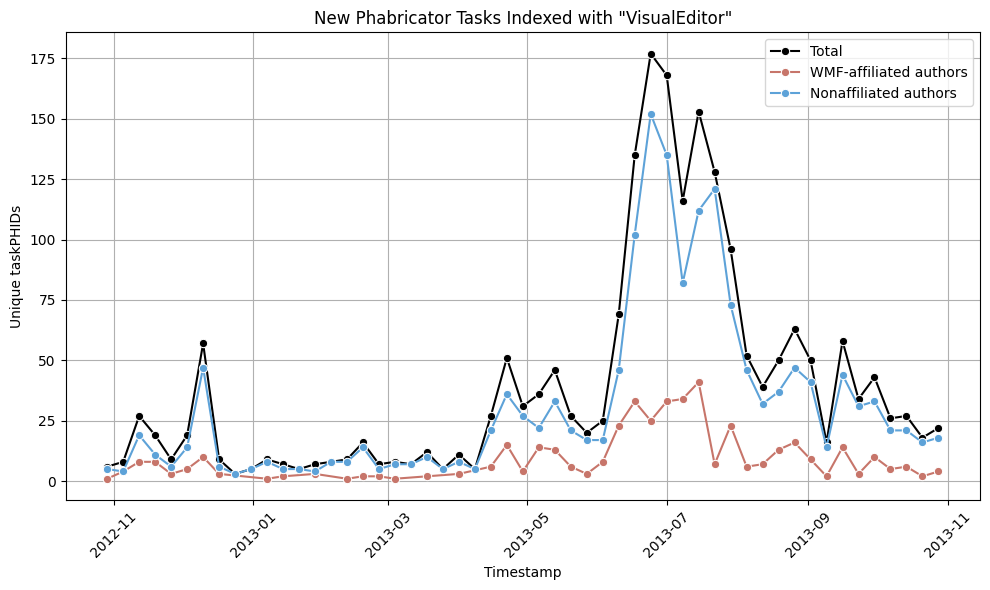

In [66]:
plt.figure(figsize=(10, 6))
task_phab_df = comment_phab_df[filtered_phab_df['comment_type']=="task_description"]
task_phab_df['week'] = task_phab_df['timestamp'].dt.to_period('W').dt.start_time
unique_taskPHIDs = task_phab_df.groupby('week')['conversation_id'].nunique()

wmf_task_phab_df = task_phab_df[task_phab_df['meta.affil'] == True]
wmf_tasks = wmf_task_phab_df.groupby('week')['conversation_id'].nunique()

other_task_phab_df = task_phab_df[task_phab_df['meta.affil'] != True]
other_tasks = other_task_phab_df.groupby('week')['conversation_id'].nunique()

sns.lineplot(x=unique_taskPHIDs.index, y=unique_taskPHIDs.values, color='black', label='Total', marker='o')
sns.lineplot(x=wmf_tasks.index, y=wmf_tasks.values, color='#c7756a', label='WMF-affiliated authors', marker='o')
sns.lineplot(x=other_tasks.index, y=other_tasks.values, color='#5da2d8', label='Nonaffiliated authors', marker='o')
plt.title('New Phabricator Tasks Indexed with "VisualEditor"')
plt.xlabel('Timestamp')
plt.ylabel('Unique taskPHIDs')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


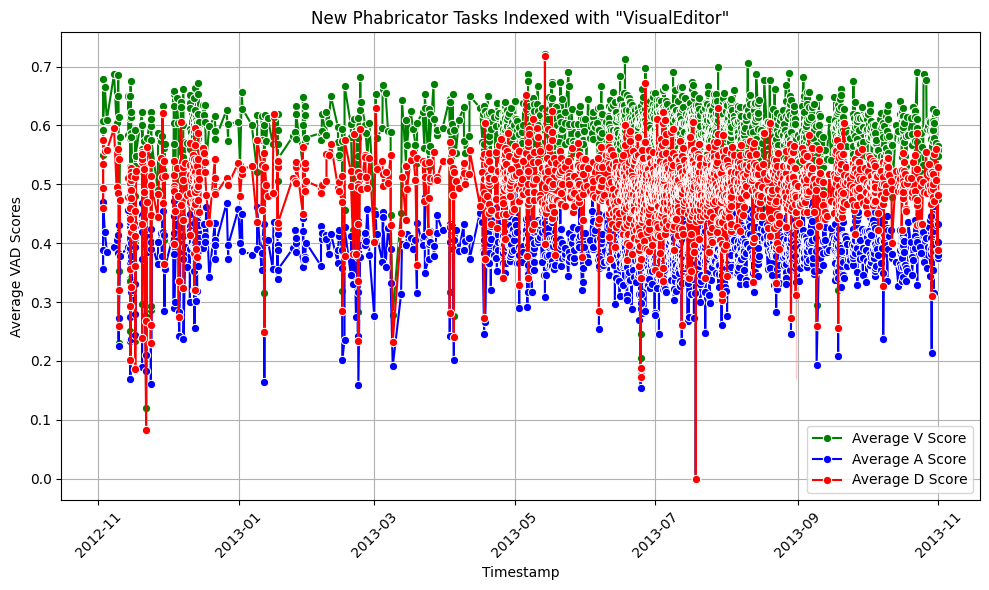

In [73]:
grouped_df = comment_phab_df.groupby('conversation_id').agg({
    'average_v_score': 'mean',
    'average_a_score': 'mean',
    'average_d_score': 'mean',
    'timestamp': 'first',  # Assuming we want the first timestamp in each conversation
    'meta.affil': 'first'  # Assuming we want the first affiliation in each conversation
}).reset_index()

plt.figure(figsize=(10, 6))


sns.lineplot(x=grouped_df['timestamp'], y=grouped_df['average_v_score'], color='green', label='Average V Score', marker='o')
sns.lineplot(x=grouped_df['timestamp'], y=grouped_df['average_a_score'], color='blue', label='Average A Score', marker='o')
sns.lineplot(x=grouped_df['timestamp'], y=grouped_df['average_d_score'], color='red', label='Average D Score', marker='o')

plt.title('New Phabricator Tasks Indexed with "VisualEditor"')
plt.xlabel('Timestamp')
plt.ylabel('Average VAD Scores')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

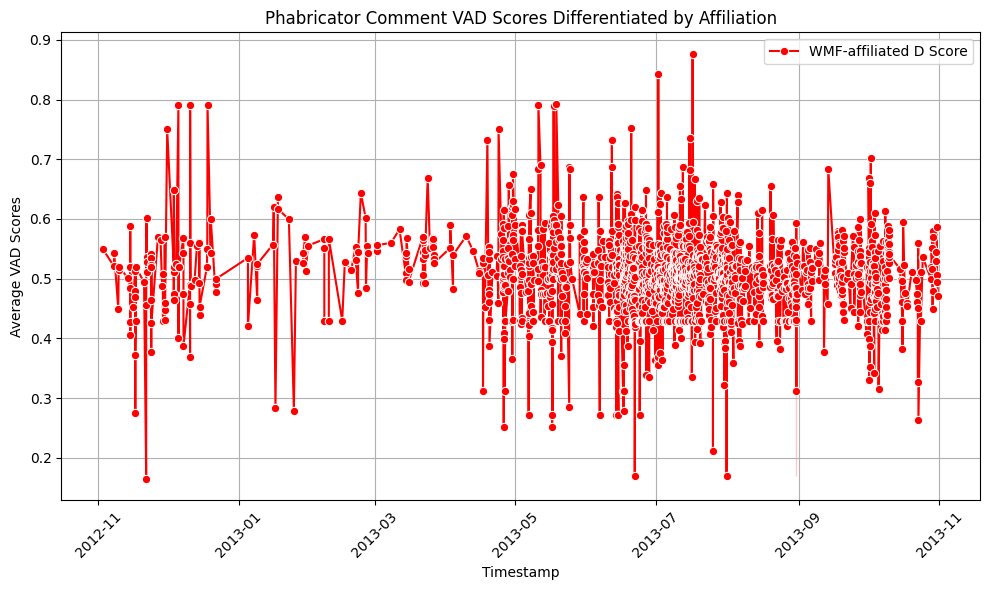

In [81]:
plt.figure(figsize=(10, 6))

# Plotting VAD scores for WMF-affiliated authors
wmf_comments_df = comment_phab_df[(comment_phab_df['meta.affil'] == True)  & comment_phab_df['average_d_score'] != 0]
#sns.lineplot(x=wmf_comments_df['timestamp'], y=wmf_comments_df['average_v_score'], color='green', label='WMF-affiliated V Score', marker='o')
#sns.lineplot(x=wmf_comments_df['timestamp'], y=wmf_comments_df['average_a_score'], color='blue', label='WMF-affiliated A Score', marker='o')
sns.lineplot(x=wmf_comments_df['timestamp'], y=wmf_comments_df['average_d_score'], color='red', label='WMF-affiliated D Score', marker='o')

# Plotting VAD scores for non-affiliated authors
non_affil_comments_df = comment_phab_df[(comment_phab_df['meta.affil'] != True) & (comment_phab_df['average_d_score'] != 0)]
#sns.lineplot(x=non_affil_comments_df['timestamp'], y=non_affil_comments_df['average_v_score'], color='green', linestyle='--', label='Non-affiliated V Score', marker='x')
#sns.lineplot(x=non_affil_comments_df['timestamp'], y=non_affil_comments_df['average_a_score'], color='blue', linestyle='--', label='Non-affiliated A Score', marker='x')
#sns.lineplot(x=non_affil_comments_df['timestamp'], y=non_affil_comments_df['average_d_score'], color='blue', linestyle='--', label='Non-affiliated D Score', marker='o')

plt.title('Phabricator Comment VAD Scores Differentiated by Affiliation')
plt.xlabel('Timestamp')
plt.ylabel('Average VAD Scores')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()